<a href="#readinput">Read input</a><br>
<a href="#preprocess_sample_data">Preprocess sample data</a><br>
<a href="#corpuses">Text preprocessing</a><br>
<a href="#features">Feature engineering</a><br>
<a href="#advanced_features">Advanced features</a><br>
<a href="#image_caption">Image Captioning</a><br>
<a href="#Prediction">Predictions</a>

## Import libraries

In [40]:
%cd ~/bdp_bipm

/home/sardor_antje_kristina/bdp_bipm


In [1]:
import os, json, sys
import shutil
import multiprocessing
from tempfile import mkdtemp
from joblib import Memory
import copy
import pickle

import pandas as pd
import numpy as np
import random
from numpy import zeros
from scipy.linalg import svd
import scipy

import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem.lancaster import LancasterStemmer
from nltk.tag.stanford import StanfordPOSTagger
from nltk.corpus import words as nltk_words

from scipy import misc
from textblob import TextBlob
import textacy
import spacy
from fuzzywuzzy import fuzz

import gensim, logging
from gensim import similarities
from gensim.models import Phrases, word2vec, doc2vec
from gensim.models.phrases import Phraser
from gensim.models.keyedvectors import KeyedVectors
import time
from functools import reduce
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
import xgboost as xgb

import seaborn as sns
import string
import math
from urllib.parse import urlparse
from collections import Counter

from wordcloud import WordCloud
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn import linear_model
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from imp import reload

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/lib/python3/dist-packages/matplotlib/__init__.py:874: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Import Data From MongoDB

## Define constants

In [ ]:
#stTagger = StanfordPOSTagger(model_filename='../stanford-postagger-full-2016-10-31/models/english-bidirectional-distsim.tagger', 
#                       path_to_jar= '../stanford-postagger-full-2016-10-31/stanford-postagger.jar')
w2vModel = KeyedVectors.load_word2vec_format('glove_6B_50d.txt', binary=False)
lancas = LancasterStemmer()
wnl = nltk.WordNetLemmatizer()

prepositions = set(["by","around", "at", "away", "down", "in", "off", "on", "out", "over", "round", "up", "upon", "onto", "through", "against", "under", "aside", "between", "before", "with", "without", "forward", "behind", "without", "across", "as", "back", "apart", "after", "away", "towards", "ahead", "along", "of", "past", "aback", "about", "above", "apart", "aside", "way", "to"])
negationWords = set(["not","without","no","never"])
POS_list = ["$","''","(",")",",","--",".",":","CC","CD","DT","EX","FW","IN","JJ","JJR","JJS","LS","MD","NN","NNP","NNPS","NNS","PDT","POS","PRP","PRP$","RB","RBR","RBS","RP","SYM","TO","UH","VB","VBD","VBG","VBN","VBP","VBZ","WDT","WP","WP$","WRB","``"]
NE_list = set(["ORGANIZATION","PERSON","LOCATION","DATE","TIME","MONEY","PERCENT","FACILITY","GPE"])
posToWn = {"N":wn.NOUN,"V":wn.VERB,"J":wn.ADJ,"R":wn.ADV}

## Global variables

In [3]:
from columnconstants import *

In [4]:
sample_of_rows_size = 100000 #max 1.4 mln
sample_of_cats_size = 100 # max 860

## Tuning parameters

In [6]:
class TuningParameters:
    title_importance = 1.0
    form_phrases_count = 10
    phrases_bigram_weight = 1.0
    phrases_trigram_weight = 1.0
    titles_weight = 1.0
    fuzzy_word_threshold = 77
    
number_of_cores = max(multiprocessing.cpu_count() - 5,1)

<p id="readinput"/>
### Read input (remove uncategorized and less than 10 lots in a category)
Created objects:<br>
<ul>
<li>df_lots</li>
<li>df_categories</li>
</ul>

In [7]:
def cut_off_uncategorised(df):
    return df.loc[df[target_column]!=misc_categorylabel]

def cut_off_cats(df,single_cats):
    return df.loc[scipy.logical_not(df[target_column].isin(single_cats))]

def boolToInt(x):
    if x == "True":
        return 1
    else:
        return 0
    
df_lots = pd.read_pickle(pickle_dir+"df_lots_all.pkl")
df_categories = pd.read_pickle(pickle_dir+"df_categories.pkl")

df_lots = df_lots[df_lots[target_column].notnull()]
df_lots["is_from_marketplace"] = df_lots["is_from_marketplace"].apply(boolToInt)
df_lots = cut_off_uncategorised(df_lots)

single_cats = [k for k, v in Counter(df_lots[target_column]).items() if v < 50]
df_lots = cut_off_cats(df_lots,single_cats)

In [101]:
import DataExploration

In [ ]:
df_lots[df_lots['manufacturer_normalized'].notnull()]['manufacturer_normalized']

In [108]:
len(df_lots[df_lots['manufacturer_normalized'].notnull()]['manufacturer_normalized'].unique())

4817

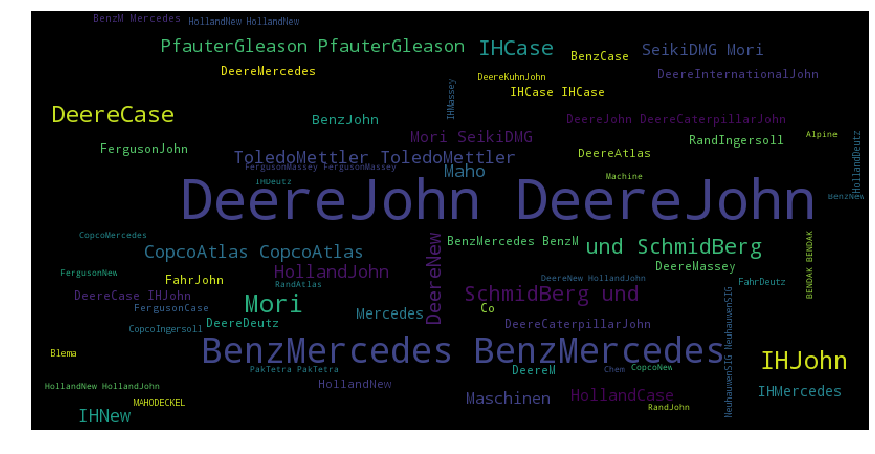

In [106]:
DataExploration.showSeriesWordCloud(df_lots[df_lots['manufacturer_normalized'].notnull()].loc[:100000,'manufacturer_normalized'])

In [ ]:
[i for i in df_lots[df_lots['manufacturer_normalized'].notnull()]['manufacturer_normalized'] if i.startswith('U')]

# Create category graph

<i>Created objects: <strong>cats_graph</strong> (alias G) networkx DiGraph for categories</i>

In [10]:
import networkx as nx

In [11]:
df_categories['_id'].size

970

In [12]:
cats_graph = nx.DiGraph()
rootNode = "root"

def fill_category_graph(cats_graph,numberOfElements=1000):
    for toNode,fromNode in zip(df_categories['_id'].values,df_categories['parent_id'].values):
        if fromNode != fromNode:#to check the null
            cats_graph.add_edge(rootNode,str(toNode))
        else:
            cats_graph.add_edge(fromNode,str(toNode))

fill_category_graph(cats_graph)          

In [ ]:
nx.draw(cats_graph)

In [ ]:
y = nx.degree_histogram(cats_graph)
x = np.arange(len(y))

In [ ]:
sns.barplot(x,[math.log(i+1) for i in y])

In [ ]:
nx.info(cats_graph,n=misc_categorylabel)

In [ ]:
nx.info(cats_graph,n="531600b378f860d0398b457a")

In [ ]:
cats_graph.subgraph("531600ae78f860d0398b4567")

### Total number of nodes

In [69]:
cats_graph.number_of_nodes()

971

### Total number of leaves

In [13]:
G = cats_graph
len([x for x in G.nodes_iter() if G.out_degree(x)==0 and G.in_degree(x)==1])

865

### Total number of the 3rd level categories

In [90]:
len([v for v in nx.shortest_path_length(G,rootNode).values() if v==3])

653

In [ ]:
nx.shortest_path_length(G,rootNode)

### High level categories

In [70]:
len(cats_graph[rootNode])

35

In [ ]:
del x,y

<p id ="preprocess_sample_data" />
# Preprocessing Data for exploration and further use

Created objects:<br>
<ul>
<li><strong>oldNodes</strong>: not existing categories</li>
<li><strong>a</strong>: the distances between root and each category</li>
</ul>
Updated objects:<br>
<ul>
<li><strong>df_lots</strong>: not existing categories</li>
</ul>

In [14]:
#Checking if categories on different levels
a = []
oldNodes = []
for i in df_lots[target_column].unique():
    if G.has_node(i):
        a.append(nx.shortest_path_length(G,source=rootNode,target=i))
        #totalNodes += 1
    else:
        oldNodes.append(i)
        
np.mean(a)

2.5542168674698793

In [73]:
print(np.sum(np.array(a)<1000))

581


#### Categories on 3 levels

In [72]:
print("1 = ",np.sum(np.array(a) == 1))
print("2 = ",np.sum(np.array(a) == 2))
print("3 = ",np.sum(np.array(a) == 3))

1 =  30
2 =  199
3 =  352


### Cut off uncategorised lots

In [15]:
def cut_off_non_existing(df):
    return df.loc[scipy.logical_not(df[target_column].isin(oldNodes))]

df_lots = cut_off_non_existing(df_lots)

### Train and test split

X_train, X_test, y_train, y_test

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df_lots.drop(target_column,axis=1), df_lots[target_column], test_size = 1-sample_of_rows_size/df_lots[target_column].size, stratify=df_lots[target_column], random_state=21)


### Get full texts

In [36]:
def cleanStr(s):
    return textacy.preprocess.preprocess_text(str(s),fix_unicode=True, lowercase=False, transliterate=True,
                    no_urls=True, no_emails=True, no_phone_numbers=True,
                    no_numbers=True, no_currency_symbols=True, no_punct=True,
                    no_contractions=True, no_accents=True)

In [22]:
def get_numeric_fields(df):
    return df.loc[:,numeric_columns_list].applymap(lambda x: x if type(x) == int else np.NaN)

def get_en_text_fields(df):
    return df.loc[:,set_of_cols_en].fillna("")

def get_de_text_fields(df):
    return df.loc[:,set_of_cols_de].fillna("")

text_sum = lambda series : reduce(lambda x, y: cleanStr(x) +" " + cleanStr(y), series)

def get_full_descriptions(df):
    return pd.DataFrame({"transtions.en.full.description":get_en_text_fields(df).apply(text_sum,reduce = True, axis = 1).values, 
                         "transtions.de.full.description":get_de_text_fields(df).apply(text_sum,reduce = True, axis = 1).values})

def get_full_en_descriptions(df):
    return pd.Series(name="transtions.en.full.description",data=get_en_text_fields(df).apply(text_sum,reduce = True, axis = 1).values)

def get_full_de_descriptions(df):
    return pd.Series(name="transtions.de.full.description",data=get_de_text_fields(df).apply(text_sum,reduce = True, axis = 1).values)

def get_non_translate_columns(df):
    return df.loc[:,grouping_non_translate_columns].fillna("")

def get_categorical_values(df):
    return pd.DataFrame({'country':pd.factorize(df['country'])[0], 'city':pd.factorize(df['city'])[0], 'lang':pd.factorize(df['lang'])[0], 'url':pd.factorize(df['url'].map(lambda x:urlparse(x).netloc, na_action='ignore'))[0]},dtype = 'category')

#sample_df_lots.set_index(target_column,inplace=True)

#sample_df_lots = sample_df_lots[grouping_non_translate_columns]

#### Create labels for each level

In [16]:
def findLevel(node,G,n):
    if G.has_node(node):
        shp = nx.shortest_path_length(G,source=rootNode,target=node)
        res = np.full(3, node)
        curNode = node
        for i in range(3-shp+1,3):
            curNode = G.predecessors(curNode)[0]
            res[i] = curNode
        return res[n]
    else:
        return node
    
assert findLevel("531600ae78f860d0398b4567",G,1) == "531600ae78f860d0398b4567"
assert findLevel("531600ae78f860d0398b4567",G,0) == "531600ae78f860d0398b4567"
assert findLevel("531600ae78f860d0398b4567",G,2) == "531600ae78f860d0398b4567"

assert findLevel("531600b378f860d0398b457a",G,0) == "531600b378f860d0398b457a"
assert findLevel("531600b378f860d0398b457a",G,2) == "531600ae78f860d0398b4567"
assert findLevel("531600b378f860d0398b457a",G,1) == "531600af78f860d0398b456c"

In [161]:
def create_category_level_columns(df):
    return pd.DataFrame({target_column+"_2":df[target_column].apply(findLevel,args=(G,1)).values, 
                        target_column+"_3":df[target_column].apply(findLevel,args=(G,2)).values})

def create_category_level_columns_series(sr):
    return pd.DataFrame({target_column+"_2":sr.apply(findLevel,args=(G,1)).values, 
                        target_column+"_3":sr.apply(findLevel,args=(G,2)).values})

#sample_df_lots[target_column+"_2"] = sample_df_lots[target_column].apply(findLevel,args=(G,1))
#sample_df_lots[target_column+"_3"] = sample_df_lots[target_column].apply(findLevel,args=(G,2))

y_train_s = create_category_level_columns_series(y_train)
y_test_s = create_category_level_columns_series(y_test)

y_train_2 = y_train_s[target_column+"_2"]
y_train_3 = y_train_s[target_column+"_3"]

y_test_2 = y_test_s[target_column+"_2"]
y_test_3 = y_test_s[target_column+"_3"]

In [ ]:
# print("3rd level ",sample_df_lots[target_column].unique().shape)
# print("2nd level ",sample_df_lots[target_column+"_2"].unique().shape)
# print("1st level ",sample_df_lots[target_column+"_3"].unique().shape)

In [ ]:
def factorize_target(df):
    return df.loc[:,[target_column,target_column+"_2",target_column+"_3"]].apply(lambda x:pd.factorize(x)[0]) #df[[target_column,target_column+"_2",target_column+"_3"]] =

#sample_df_lots = factorize_target(df)

# Corpuses

In [42]:
grouped_titles_descriptions = pd.read_pickle(pickle_dir+"grouped_by_cat_text_columns_full.pkl")

In [152]:
grouped_titles_descriptions.columns

Index(['foreign_category_label', 'machine_type', 'manufacturer',
       'manufacturer_normalized', 'translations.de.description',
       'translations.de.title', 'translations.en.description',
       'translations.en.title', 'transtions.en.full.description',
       'transtions.de.full.description'],
      dtype='object')

In [ ]:
grouped_titles_descriptions['transtions.en.full.description'].apply(len).describe()

### Generate text stream

In [43]:
def seriesToDict(ser):
    return [{"key":key,"value":value} for key, value in zip(ser.index,ser)]

def streamAndMeta(ser):
    return textacy.fileio.split_record_fields(seriesToDict(ser), 'value')

def corpusFromSeriesDoc(ser,lang="en"):
    text_stream_en, metadata_stream_en = streamAndMeta(ser)
    return textacy.Corpus(lang, docs=text_stream_en, metadatas = metadata_stream_en)

def corpusFromSeriesText(ser,lang="en"):
    text_stream_en, metadata_stream_en = streamAndMeta(ser)
    return textacy.Corpus(lang, texts=text_stream_en, metadatas = metadata_stream_en)

## Phraser

In [44]:
starttime = time.time()

records_en = [{"key":key,"value":"# "+value} for key, value in grouped_titles_descriptions["transtions.en.full.description"].to_dict().items()]
records_de = [{"key":key,"value":"# "+value} for key, value in grouped_titles_descriptions["transtions.de.full.description"].to_dict().items()]
print("Finish time Phraser = ",time.time()-starttime)

Finish time Phraser =  1.7448158264160156


In [45]:
starttime = time.time()
lang_records = {}
lang_records['en'] = [f['value'].split(" ") for f in records_en]
lang_records['de'] = [f['value'].split(" ") for f in records_de]
print("Finish time ",time.time()-starttime)

Finish time  76.5110216140747


In [27]:
from sklearn.base import BaseEstimator, TransformerMixin
class Cust_phraser(BaseEstimator, TransformerMixin):
    def __init__(self, parse=True, lang="en", min_count=20, threshold=7):
        self.min_count = min_count
        self.threshold = threshold
        self.lang = lang
        self.parse = parse
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, x):
        if self.parse == False:
            return x
        
        phrases = Phrases(lang_records[self.lang], min_count=self.min_count, threshold=self.threshold)
        bigramPhraser = Phraser(phrases)
        return x.map(lambda x:" ".join(bigramPhraser[x.split(" ")]))
# less than 5 minutes

<div id="features"></div>
# Feature engineering

## Simple features

In [ ]:
#DataExploration.showSeriesWordCloud(df_categories["translations.en.title"])

In [ ]:
#finalSDF = pd.DataFrame(pd.Series(np.zeros(sample_of_rows_size),index = finalDF.index.values.tolist()))

In [21]:
from synsetsimilarity import synMatchWord, synMatchEmbedWord

In [22]:
assert (math.floor(synMatchWord([("I","NN"),("loosing","VB"),("beautiful","JJ"),("competition","NN")],[("I","NN"),("love","VB"),("not","DT"),("ugly","JJ"),("competition","NN")]))==25),"Synmatch is failed"
assert (math.floor(synMatchWord([("I","NN"),("look","VB"),("for","PP"),("beautiful","JJ"),("competition","NN")],[("I","NN"),("search","VB"),("not","DT"),("ugly","JJ"),("competition","NN")]))==0),"Synmatch is failed"
#assert (math.floor(synMatchEmbedWord(["Hen","men","beautiful","competition"],["Chicken","women","not","ugly","competition"]))==25),"Synmatch is failed"

In [ ]:
#%timeit for i in range(1000000): fuzzMatch("stfasfasf1","Fsasfasfasfasafsasf","fasfsafsfasfa")

In [25]:
cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=0)

def synMatch(st1,st21,st22,threshold):
    try:
        st1 = nltk.pos_tag(st1.split(" "))
        st21 = nltk.pos_tag(st21.split(" "))
        st22 = nltk.pos_tag(st22.split(" "))
        res = max((synMatchWord(st1,st21),synMatchWord(st1,st22)))
    except:
        res = 0
    if res > threshold:
        return 1
    else:
        return 0
    
memory.cache(func=synMatch)

def fuzzMatch(st1,st21,st22,threshold):
    try:
        res = max((fuzz.ratio(st1,st21),fuzz.ratio(st1,st22)))
    except:
        res = 0
    if res > threshold:
        return 1
    else:
        return 0
memory.cache(func=fuzzMatch)
    
def fuzzMatchPercent(st1,st21,st22,threshold):
    try:
        res = max((fuzz.ratio(st1,st21),fuzz.ratio(st1,st22)))
    except:
        res = 0
    return res
    
memory.cache(func=fuzzMatchPercent)

def build_for_cat_matching_feat(df, f=fuzzMatchPercent, thres=70, categories_df=df_categories, col="foreign_category_label"):
    gen = categories_df[["translations.en.title","translations.de.title"]].iterrows()
    return pd.DataFrame({ "foreign_cat_match"+str(row[0]):df[col].apply(f,args=(row[1][0],row[1][1],thres)) for row in gen},index=df.index)


class Cust_cat_fuzz_matcher(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=77):
        self.threshold = threshold
    
    def fit(self, x, y=None):
        return self
        
    def transform(self, x):
        return build_for_cat_matching_feat(x,fuzzMatch,self.threshold)
    
class Cust_cat_fuzz_matcher_percent(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=77):
        self.threshold = threshold
    
    def fit(self, x, y=None):
        return self
        
    def transform(self, x):
        return build_for_cat_matching_feat(x,fuzzMatchPercent,self.threshold)
    
    
class Cust_cat_syn_matcher(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=70):
        self.threshold = threshold
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, x):
        return build_for_cat_matching_feat(x,synMatch,self.threshold)
    


def inDesc(st1,st21,st22):
    try:
        res = max(st1.find(st21),st1.find(st22))
    except:
        res = 0
    if res > -1:
        return 1
    else:
        return 0


#gen = df_categories[["translations.en.title","translations.de.title"]].iterrows()
#for row in gen:
#    finalSDF["foreign_cat_match"+str(row[0])] = lots_sample_df["foreign_category_label"].apply(fuzzMatch,args=(row[1][0],row[1][1]))

In [50]:
test1 = Cust_cat_fuzz_matcher(threshold=90)

In [46]:
%timeit build_for_cat_matching_feat(X_train.iloc[:100],synMatch,70) #6:24
%timeit build_for_cat_matching_feat(X_train.iloc[:10000],fuzzMatch,70) #1:24

1 loop, best of 3: 6min 24s per loop


<div id="advanced_features"></div>
## Advanced features

# Word vectors

In [ ]:
w2vDocmodel = {}
for k,corpus in corpuses:
    w2vDocmodel[k] += [word2vec.Word2Vec(doc.tokenized_text, size=64, window=5, min_count=1, workers=10, hs=1, negative=0)  for doc in corpus]

In [ ]:
np.avg([1,2,3])

In [ ]:
#corpuses['normal.en'][1][:20]

In [ ]:
for w2vectorDocs in w2vDocmodel["normal.en"]:
    for i,w2vectorDoc in enumerate(w2vectorDocs):
        finalSDF["w2v"+str(i)] = sample_df_lots["translations.en.full.description"].apply(lambda x:w2vectorDoc.score([x.split(" ")])[0])

In [ ]:
w2vPharsermodel = word2vec.Word2Vec(bigramPhraser[corpuses['normal.en'].text], size = 50)


<p id="prediction"/>
# Prediction

In [199]:
eng_desc_features123 = ('fd_features', Pipeline([
                    ('selector', FunctionTransformer(get_full_en_descriptions,validate=False)),
                    ('phraser',Cust_phraser()),
                    ('vectorizer', TfidfVectorizer()),
                    ('dim_red', TruncatedSVD(n_components=500))
                ]) )

eng_desc_features123[1].fit(X_train,y_train)

Pipeline(steps=[('selector', FunctionTransformer(accept_sparse=False,
          func=<function get_full_en_descriptions at 0x7f396afbfa60>,
          inv_kw_args=None, inverse_func=None, kw_args=None, pass_y=False,
          validate=False)), ('phraser', Cust_phraser(lang='en', min_count=20, parse=True, thre...runcatedSVD(algorithm='randomized', n_components=500, n_iter=5,
       random_state=None, tol=0.0))])

In [ ]:
p_numeric = ('numeric_fields', Pipeline([
                    ('selector', FunctionTransformer(get_numeric_fields,validate=False)),
                    ('imputer', Imputer(missing_values=np.NaN, strategy="mean", axis=0))
                ]))

eng_desc_features = ('fd_features', Pipeline([
                    ('selector', FunctionTransformer(get_full_en_descriptions,validate=False)),
                    ('phraser',Cust_phraser()),
                    ('vectorizer', TfidfVectorizer()),
                    ('dim_red', TruncatedSVD())
                ]) )

#hierarchy_features = ('')

categorical_features = ('cat_features', Pipeline([
                    ('selector', FunctionTransformer(get_categorical_values,validate=False)),
                    ('imputer', Imputer(missing_values=-1,strategy="most_frequent"))
                    
                ]))

simple_features = ("simple_features", Pipeline(
    [
        ('selector', Cust_cat_fuzz_matcher_percent()),
        ('dim_red',PCA())
    ]))

clf = RandomForestClassifier()


pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                p_numeric
                ,eng_desc_features
                ,categorical_features
                ,simple_features
             ],
            n_jobs = 20
        )),
        #('int', SparseInteractions(degree=2)),
        ('scale', StandardScaler()),
        ('clf', clf)#OneVsRestClassifier(LogisticRegression()) #SGDClassifier
    ])


parameters = {
    'union__simple_features__dim_red__n_components':[100,300,500,800],
    'union__numeric_fields__imputer__strategy':['mean','median'],
    'union__fd_features__vectorizer__ngram_range':[(1,3)],
    'union__fd_features__vectorizer__max_features':[1501,2500],
    'union__fd_features__vectorizer__stop_words':["english"],
    'union__fd_features__vectorizer__lowercase':[False,True],
    'union__fd_features__vectorizer__analyzer':['word'], 
    'union__fd_features__vectorizer__token_pattern':[r'\w+'],
    'union__fd_features__vectorizer__use_idf':[True,False], 
    'union__fd_features__vectorizer__smooth_idf':[True,False], 
    'union__fd_features__vectorizer__sublinear_tf':[True,False],
    'union__fd_features__phraser__min_count':[20,50,500,1000],
    'union__fd_features__phraser__parse':[True,False],
    'union__fd_features__phraser__threshold':[7,70,200],
    'union__fd_features__dim_red__n_components':[100,500,1000,1500], #increase    
    'union__fd_features__dim_red__n_iter':[7],
    'union__transformer_weights': [{"numeric_fields":1,"fd_features":8,"cat_features":5,"simple_features":10},
                                {"numeric_fields":2,"fd_features":6,"cat_features":3,"simple_features":4},
                                {"numeric_fields":1,"fd_features":2,"cat_features":3,"simple_features":3}],
    'clf__n_estimators': [25, 50, 250, 500],
    'clf__max_features': ['auto', 'sqrt', 'log2'],
    'clf__bootstrap':[True,False],
    'clf__min_samples_leaf':[20,100,300]
}

In [211]:
grid_search = RandomizedSearchCV(pl, parameters, n_jobs=45, verbose=1,n_iter=20)

In [70]:
X_train_val = X_train.iloc[:100,:]
y_train_val = y_train.iloc[:100]

In [ ]:
grid_search.fit(X_train_val,y_train_val) #20 sec for 100

In [ ]:
pl.score(X_test.iloc[:100000,:],y_test.iloc[:100000])

# 95%

In [34]:
X_test.iloc[:100000,:].shape

(100000, 79)

In [23]:
from sklearn.metrics import log_loss
from sklearn.externals import joblib

In [28]:
grid_search = joblib.load('randomforest_randomized.pkl')

In [31]:
grid_search.best_params_

{'clf__bootstrap': False,
 'clf__max_features': 'sqrt',
 'clf__min_samples_leaf': 20,
 'clf__n_estimators': 500,
 'union__fd_features__dim_red__n_components': 1000,
 'union__fd_features__dim_red__n_iter': 7,
 'union__fd_features__phraser__min_count': 50,
 'union__fd_features__phraser__parse': True,
 'union__fd_features__phraser__threshold': 7,
 'union__fd_features__vectorizer__analyzer': 'word',
 'union__fd_features__vectorizer__lowercase': True,
 'union__fd_features__vectorizer__max_features': 2500,
 'union__fd_features__vectorizer__ngram_range': (1, 3),
 'union__fd_features__vectorizer__smooth_idf': False,
 'union__fd_features__vectorizer__stop_words': 'english',
 'union__fd_features__vectorizer__sublinear_tf': True,
 'union__fd_features__vectorizer__token_pattern': '\\w+',
 'union__fd_features__vectorizer__use_idf': False,
 'union__numeric_fields__imputer__strategy': 'median',
 'union__simple_features__dim_red__n_components': 300,
 'union__transformer_weights': {'cat_features': 3,
 

In [50]:
grid_search

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=Pipeline(steps=[('union', FeatureUnion(n_jobs=20,
       transformer_list=[('numeric_fields', Pipeline(steps=[('selector', FunctionTransformer(accept_sparse=False,
          func=<function get_numeric_fields at 0x7ff58e157158>,
          inv_kw_args=None, inverse_func=None, kw_args=None, pass_y=False,
      ...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
          fit_params={}, iid=True, n_iter=20, n_jobs=45,
          param_distributions={'union__fd_features__dim_red__n_components': [100, 500, 1000, 1500], 'union__fd_features__vectorizer__ngram_range': [(1, 3)], 'union__fd_features__phraser__threshold': [7, 70, 200], 'union__simple_features__dim_red__n_components': [100, 300, 500, 800], 'union__transformer_weight...nion__fd_features__dim_red__n_iter': [7], 'union__fd_features__vectorizer__stop_words': ['english']},
          pre_dispatch='2*n_jobs', random_st

In [52]:
grid_search.predict(X_test.iloc[:10000,:])

array(['54c641e2c45f9d34298b45be', '533944c678f860267f8b45e6',
       '54c641e5c45f9d34298b45fa', ..., '533944b378f860267f8b458e',
       '589dbab7933d172915520666', '533944b078f860267f8b457e'], dtype=object)

In [67]:
#X_train, X_test, y_train, y_test = train_test_split(df_lots.drop(target_column,axis=1), df_lots[target_column], test_size = 1-sample_of_rows_size/df_lots[target_column].size, stratify=df_lots[target_column], random_state=21)

clf_probs = grid_search.predict_proba(X_test.iloc[:100000,:])

In [63]:
clf_probs.shape

(10000, 581)

In [68]:
score = log_loss(y_test.iloc[:100000], clf_probs, labels = df_lots[target_column].unique())
print("LogLoss = ")
print(score)

LogLoss = 
0.828481559673
